### Imports

In [1]:
import numpy as np                             # numerical methods
import pandas as pd                            # tabular data
import seaborn as sns                          # plotting
import plotly.express as px                    # plotting
import matplotlib.pyplot as plt                # plotting
from plotly.subplots import make_subplots      # plotting
from scipy.stats import chi2, chi2_contingency # statistical analysis
from scipy.special import binom                # statistical analysis
from datetime import date, timedelta           # handling datetime objects 

### Preprocessing

In [2]:
raw = pd.read_parquet('escooter_history.parquet')

In [3]:
# create copy
df = raw.copy()

# fix data types
df = df.astype({
    "holiday": "boolean",
    "workingday": "boolean",
    "weather": "category"
})
# fix typo in weather
df.weather.cat.rename_categories(
    {"heacy rain or thunderstorm or snow or ice pallets": "heavy rain or thunderstorm or snow or ice pallets"}, inplace=True
)

# add shortcut to datetime.dt
dt = df["datetime"].dt

# add day and month name as new column
df["weekday"] = dt.day_name(locale="german")
df["month"] = dt.month_name(locale="german")
df["month_p"] = dt.to_period("M").astype("str")
df["quarter"] =  dt.to_period("Q").astype("str")


In [4]:
# conduct χ² for weather - registered customer relationship
weather_stats = chi2_contingency(pd.crosstab(df['weather'], df['registered_customer'], margins=False, normalize = False), correction=False)
# conduct χ² for holiday - registered customer relationship
holiday_stats = chi2_contingency(pd.crosstab(df['holiday'], df['registered_customer'], margins=False, normalize = False), correction=False)
# conduct χ² for working day - registered customer relationship
wday_stats = chi2_contingency(pd.crosstab(raw['workingday'], raw['registered_customer'], margins=False, normalize = False), correction=False)
# save in DataFrame
df_stats = pd.DataFrame([
    ["...Werktag & ob Kunde registriert", *wday_stats],
    ["...Feiertag & ob Kunde registriert", *holiday_stats],
    ["...Wetter & ob Kunde registriert", *weather_stats]])
# rename columns
df_stats.columns = ["Abhängigkeit zwischen...", "Teststatistik χ²", "p-Wert", "Freiheitsgrade", "Signifikant"]
# add column Signifikant
df_stats["Signifikant"] = df_stats["p-Wert"] < 0.05
df_stats

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
0,...Werktag & ob Kunde registriert,153121.729287,0.0,1,True
1,...Feiertag & ob Kunde registriert,2767.884787,0.0,1,True
2,...Wetter & ob Kunde registriert,5578.580022,0.0,3,True


### Duplikate

In [5]:
# explore duplicates
print(f"Von {len(df)} Datumswerten sind {df.datetime.nunique()} einzigartig, es doppeln sich also {len(df)-df.datetime.nunique()}.")
print(f"Jedes Duplikat ist dabei maximal {df.groupby('datetime')['temp'].count().max()} Mal vorhanden.")

Von 3296021 Datumswerten sind 3138526 einzigartig, es doppeln sich also 157495.
Jedes Duplikat ist dabei maximal 5 Mal vorhanden.


#### Wahrscheinlichkeit dass 5 Buchungen in der selben Sekunde auftreten:
Zu Stoßzeiten ca 1000 Buchungen pro Stunde. Daraus ergibt sich:

$$P(5 Buchungen/sek) = \binom{1000}{5}* \left( \frac{1}{3600} \right)^5* \left(\frac{3599}{3600} \right)^{995}$$

In [6]:
print(f"Die Wahrscheinlichkeit zu Stoßzeiten liegt damit bei ca. {round(binom(1000,5) * (1/3600)**5 * (3599/3600)**995*100, 5)}%")

Die Wahrscheinlichkeit zu Stoßzeiten liegt damit bei ca. 0.00103%


## Optimaler Ladezeitraum

In [7]:
# find out what days are usually workingdays
df.groupby("weekday", sort=False).agg({"workingday": pd.Series.mode})

,workingday
weekday,
Tuesday,False
Wednesday,False
Thursday,True
Friday,True
Saturday,True
Sunday,True
Monday,True


In [8]:
# create new DataFrame from dates
df_weekday = df[["datetime", "weekday"]].copy()
# save order as list
weekdays = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
# create dummies for weekday and group by hour, counting occurences of each day-hour combination
df_weekday = pd.get_dummies(df_weekday, prefix="", prefix_sep="").groupby(df_weekday["datetime"].dt.hour).agg({day: "sum" for day in weekdays})
# rename index
df_weekday.index.rename("Stunde", inplace = True)
# set figure size and display heatmap
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(df_weekday)

SpecificationError: Column(s) ['Dienstag', 'Donnerstag', 'Freitag', 'Mittwoch', 'Montag', 'Samstag', 'Sonntag'] do not exist

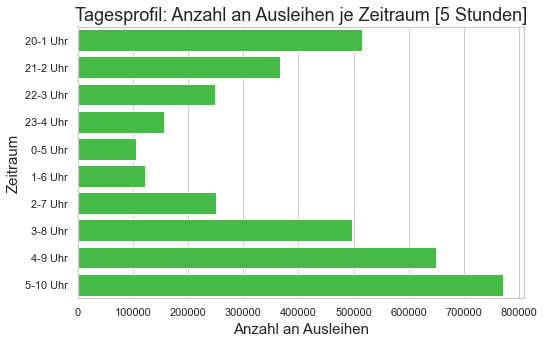

In [9]:
# keep track of interesting timeslots
slots = [[20,21,22,23,0,1], [21,22,23,0,1,2], [22,23,0,1,2,3], [23,0,1,2,3,4], *[[*range(start, start+6)] for start in range(6)]]
# create dataframe mapping slot to number of rentals in slot
df_timeslot = pd.DataFrame({"Zeitraum": [f"{slot[0]}-{slot[-1]} Uhr" for slot in slots],
                            "Anzahl an Ausleihen": [len(df.loc[dt.hour.isin(slot)]) for slot in slots]})
# display as horizontal bar chart
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
sns.set_context('notebook', rc={"axes.titlesize":18,"axes.labelsize":15})
fig = sns.barplot(x=df_timeslot['Anzahl an Ausleihen'], y=df_timeslot["Zeitraum"], color='limegreen').set(title='Tagesprofil: Anzahl an Ausleihen je Zeitraum [5 Stunden]')

## Tagesprofil

In [55]:
# create working copy
df_by_hour = df.copy()
# create column hour
df_by_hour["hour"] = dt.hour
# group by hour, registered_customer & workingday
df_by_hour = df_by_hour.groupby(["hour", "registered_customer", "workingday"], as_index=False).count()

# display daily development on working days
fig = px.histogram(df_by_hour[df_by_hour["workingday"]==1], 
                   x="hour", 
                   y="temp", 
                   color="registered_customer",
                   color_discrete_sequence = ['silver','limegreen'],
                   template = 'xgridoff',
                   labels = {'registered_customer':'Registrierter Nutzer',
                            'sum of temp': 'Anzahl der Nutzungen',
                            'hour':'Uhrzeit'},
                   nbins=24)
fig.update_layout(title="Tagesprofil: Nutzung Werktags nach Registrierung", xaxis_title="Uhrzeit", yaxis_title="Anzahl der Nutzungen")
fig.show()
# display daily developments on days off
fig = px.histogram(df_by_hour[df_by_hour["workingday"]==0],
                   x="hour",
                   y="temp",
                   color="registered_customer",
                   color_discrete_sequence = ['silver','limegreen'],
                   template = 'xgridoff',
                   labels = {'registered_customer':'Registrierter Nutzer',
                            'sum of temp': 'Anzahl der Nutzungen',
                            'hour':'Uhrzeit'},
                   nbins=24)
fig.update_layout(title="Tagesprofil: Nutzung Wochenende/Feiertag nach Registrierung", xaxis_title="Uhrzeit", yaxis_title="Anzahl der Nutzungen")
fig.show()

## Entwicklung von Ausleihen

In [36]:
# draw lineplot of count grouped by quarter
fig = px.line(df.groupby("quarter",as_index=False).count(), x="quarter", 
              y="registered_customer",
              template='plotly_white',
              color_discrete_sequence = ['limegreen'])
fig.update_layout(title="Absolute Entwicklung der Nutzung nach Quartalen", xaxis_title="Quartal", yaxis_title="Anzahl der Nutzungen")

In [52]:
# group by month and registered customer
df_ratio_19 = df[dt.year == 2019].groupby(["month"], sort=False, as_index=False).count()
df_ratio_20 = df[dt.year == 2020].groupby(["month"], sort=False, as_index=False).count()
# compute ratio
df_ratio_19["ratio"] = df_ratio_19["temp"] / df_ratio_19["temp"].shift(1)
df_ratio_20["ratio"] = df_ratio_20["temp"] / df_ratio_20["temp"].shift(1)
# display line plot

fig = px.line(df_ratio_19, 
              x="month", 
              y="ratio",
              color_discrete_sequence =['limegreen'],
              template='plotly_white')
fig.add_trace(px.line(df_ratio_20, x="month", y="ratio", color_discrete_sequence=['black']).data[0])
             
fig.update_layout(title="Relative Entwicklung der monatlichen Nutzung pro Jahr", 
                  xaxis_title="Monat", 
                  yaxis_title="Verhältnis der Nutzung",
                  showlegend = True)

#### Erklärung, dass 2019 der stärkste prozentuale Anstieg an Ausleihen 2019 im Mai war und 2020 im März

In [13]:
df.groupby([dt.year,"month"])[["weather","atemp"]].agg(pd.Series.mode)

# Häufigste gefühlte Temperatur war im Mai 2019 deutlich stärker als in den vorherigen Monaten und sieht nach Sommeranfang aus.
# 2020 gab es diesen Sommerbeginn bereits im März mit der gleichen häufigsten gefühlten Temperatur 

weather   atemp
datetime month                               
2019     April      clear, few clouds  22.725
         August     clear, few clouds  33.335
         December   clear, few clouds  15.150
         February   clear, few clouds  15.150
         January    clear, few clouds  11.365
         July       clear, few clouds  34.850
         June       clear, few clouds  32.575
         March      clear, few clouds  15.150
         May        clear, few clouds  31.060
         November   clear, few clouds  22.725
         October    clear, few clouds  31.060
         September  clear, few clouds  27.275
2020     April      clear, few clouds  31.060
         August     clear, few clouds  33.335
         December   clear, few clouds  19.695
         February   clear, few clouds  16.665
         January    clear, few clouds  11.365
         July       clear, few clouds  34.850
         June       clear, few clouds  31.060
         March      clear, few clouds  31.060
         May        clear, few clouds  31.060
         November   clear, few clouds  16.665
         October    clear, few clouds  31.060
         September  clear, few clouds  31.060

In [14]:
df.groupby([dt.year,"month"])[["weather","temp"]].agg(pd.Series.mode)

# Auch richtige Temperatur bestätigt die oben genannte These 

weather   temp
datetime month                              
2019     April      clear, few clouds  18.86
         August     clear, few clouds  28.70
         December   clear, few clouds  14.76
         February   clear, few clouds  13.94
         January    clear, few clouds   8.20
         July       clear, few clouds  32.80
         June       clear, few clouds  30.34
         March      clear, few clouds  13.94
         May        clear, few clouds  24.60
         November   clear, few clouds  18.86
         October    clear, few clouds  22.96
         September  clear, few clouds  27.06
2020     April      clear, few clouds  20.50
         August     clear, few clouds  31.16
         December   clear, few clouds  13.12
         February   clear, few clouds  12.30
         January    clear, few clouds   8.20
         July       clear, few clouds  32.80
         June       clear, few clouds  26.24
         March      clear, few clouds  24.60
         May        clear, few clouds  26.24
         November   clear, few clouds  14.76
         October    clear, few clouds  22.96
         September  clear, few clouds  27.06

#### Relative Entwicklung nach Quartal/Monat mit Referenz zu Geschäftseröffnung

In [15]:
# group by quarter and registered customer
df_ratio = df.groupby(["quarter", "registered_customer"], as_index=False).count()
# establish baseline
baseline_0, baseline_1 = (df_ratio.iloc[0][2], df_ratio.iloc[1][2])
# compute ratio relative to baseline
df_ratio["ratio"] = df_ratio["temp"].where(df_ratio["registered_customer"], df_ratio["temp"]/baseline_0)
df_ratio["ratio"] = df_ratio["ratio"].where(~df_ratio["registered_customer"], df_ratio["temp"]/baseline_1)

# display line plotJ
fig = px.line(df_ratio, x="quarter", 
              y="ratio", 
              color="registered_customer",
              color_discrete_sequence =['gray','limegreen'],
              template='plotly_white',
              labels = {'registered_customer':'Registrierter Nutzer'})
fig.update_layout( title="Relative Entwicklung der Nutzung im Quartal mit Referenz zu 2019Q1", xaxis_title="Monat", yaxis_title="Verhältnis der Nutzung")

In [16]:
# group by month and registered customer
df_ratio = df.groupby(["month_p", "registered_customer"], as_index=False).count()
# establish baseline
baseline_0, baseline_1 = (df_ratio.iloc[0][2], df_ratio.iloc[1][2])
# compute ratio relative to baseline
df_ratio["ratio"] = df_ratio["temp"].where(df_ratio["registered_customer"], df_ratio["temp"]/baseline_0)
df_ratio["ratio"] = df_ratio["ratio"].where(~df_ratio["registered_customer"], df_ratio["temp"]/baseline_1)

# display line plot
fig = px.line(df_ratio, 
              x="month_p", 
              y="ratio", 
              color="registered_customer",
              color_discrete_sequence =['gray','limegreen'],
              template='plotly_white',
              labels = {'registered_customer':'Registrierter Nutzer'})
             
fig.update_layout( title="Relative Entwicklung der Nutzung im Monat mit Referenz zu 2019-Januar", xaxis_title="Monat", yaxis_title="Verhältnis der Nutzung")

#### Nutzungsprofil nach Monaten

In [17]:
# draw lineplot of count grouped by month
fig = px.line(df.groupby("quarter",as_index=False).count(), x="quarter", 
              y="registered_customer",
              template='plotly_white',
              color_discrete_sequence = ['limegreen'])
fig = px.line(df.groupby("month",as_index=False, sort=False).count(), x="month", y="temp",
             template='plotly_white',
             color_discrete_sequence = ['limegreen'])
fig.update_layout( title="Nutzungsprofil nach Monaten", xaxis_title="Monat", yaxis_title="Anzahl der Nutzungen")

### Ausleihen von registrierten zu unregistrierten Nutzern pro Quartal

In [54]:
df_qu = df.groupby("quarter", as_index=False).agg(count=("temp","count"), sum_reg=("registered_customer", "sum"))
df_qu["True"] = df_qu["sum_reg"] / df_qu["count"]
df_qu["False"] = 1 - df_qu["True"]
df_qu = pd.melt(df_qu, id_vars="quarter", value_vars=["True", "False"])

fig = px.bar(df_qu,x="quarter",
       y="value",
       color="variable",
       color_discrete_sequence =['limegreen','silver'],
       template='plotly_white'
      )
fig.update_layout( title="Aufteilung der Nutzerregistrierung nach Quartalen", 
                  xaxis_title="Quartal", 
                  yaxis_title="Prozent Registrierung",
                  legend_title_text='Registrierter Nutzer'
                 )

### Noch mehr Entwicklung von Ausleihen

In [19]:
# group by month and registered customer
df_ratio = df.groupby(["month_p", "registered_customer"], as_index=False).count()
# compute ratio
df_ratio["ratio"] = df_ratio["temp"] / df_ratio["temp"].shift(2)

# display line plot
fig = px.line(df_ratio, 
              x="month_p", 
              y="ratio", 
              color="registered_customer",
              color_discrete_sequence =['gray','limegreen'],
              template='plotly_white',
              labels = {'registered_customer':'Registrierter Nutzer'})
             
fig.update_layout(title="Relative Entwicklung der monatlichen Nutzung", xaxis_title="Monat", yaxis_title="Verhältnis der Nutzung")

In [20]:
# show rentals of registered vs non-registered customers per quarter 
fig_rents_per_quarter_pc = px.line(df.groupby(["quarter","registered_customer"],as_index=False).count(), 
                                   x="quarter", 
                                   y="temp", 
                                   color="registered_customer",
                                   color_discrete_sequence =['gray','limegreen'],
                                   template='plotly_white',
                                   labels = {'registered_customer':'Registrierter Nutzer'})
fig_rents_per_quarter_pc.update_layout(title="Absolute Entwicklung der Nutzung pro Quartal nach Registrierung", xaxis_title="Quartal", yaxis_title="Anzahl der Nutzungen")

In [21]:
# show rentals of registered vs non-registered customers per month 
fig = px.line(df.groupby(["month_p","registered_customer"],as_index=False).count(), 
              x="month_p", 
              y="temp", 
              color="registered_customer",
              color_discrete_sequence =['gray','limegreen'],
              template='plotly_white',
              labels = {'registered_customer':'Registrierter Nutzer'})
fig.update_layout(title="Absolute Entwicklung der Nutzung pro Monat nach Registrierung", xaxis_title="Monat", yaxis_title="Anzahl der Nutzungen")

## Zusammenhang Werktag & Registrierung

In [22]:
pd.crosstab(raw['workingday'], raw['registered_customer'], margins=True, normalize = True)

registered_customer,False,True,All
workingday,,,
0,0.096574,0.211974,0.308548
1,0.090575,0.600877,0.691452
All,0.187149,0.812851,1.000000


Crosstab legt Abhängigkeit zwischen Registrierung und Werktag nahe: Nicht Registrierte nutzen fast gleichverteilt an Werktag/nicht Werktag, Registrierte deutlich häufiger an Werktagen
Nicht registrierte Nutzer fahren in der Summe fast genauso häufig am Wochenende wie an Arbeitsagen -> Demnach deutlich häufiger am Wochende/Feiertagen, da es ja weniger freie Tage als Werktage gibt!

In [23]:
df_stats.loc[[0]].round(2)

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
0,...Werktag & ob Kunde registriert,153121.73,0.0,1,True


#### Diese Abhängigkeit ist signifikant

[Text(0.5, 1.0, 'Verhältnis von Registrierungen nach freiem/Werktag'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Anzahl [in Mio.]')]

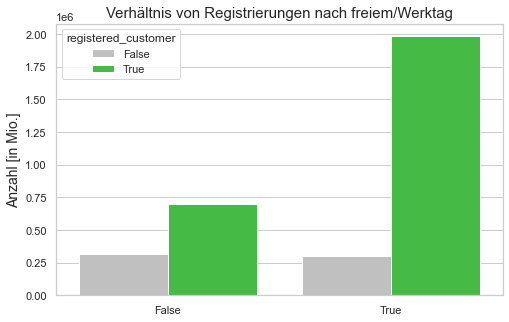

In [24]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("whitegrid")
sns.set_context('notebook', rc={"axes.titlesize":15,"axes.labelsize":14})
sns.countplot(data=df, x='workingday', hue='registered_customer',
              palette={True:'limegreen', False:'silver'},
             ).set(title='Verhältnis von Registrierungen nach freiem/Werktag',xlabel= None, ylabel = "Anzahl [in Mio.]")

#### Visualisierung des Zusammenhangs Werktag & Registrierung

## Zusammenhang Feiertag & Registrierung

In [25]:
pd.crosstab(raw['holiday'], raw['registered_customer'], margins=True, normalize = True)

registered_customer,False,True,All
holiday,,,
0,0.180245,0.792669,0.972915
1,0.006904,0.020182,0.027085
All,0.187149,0.812851,1.000000


#### Crosstab legt Abhängigkeit zwischen Registrierung und Feiertag nahe: Nicht Registrierte nutzen ca. 25x so häufig an normalen Tagen wie an Feiertagen , Registrierte hingegen ca. 40x so häufig

In [26]:
# Abhängigkeit zwischen reg_customer & holiday ist auch signifikant
df_stats.loc[[1]].round(2)

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
1,...Feiertag & ob Kunde registriert,2767.88,0.0,1,True


#### Diese Abhängigkeit ist signifikant

In [27]:
# generate DataFrames for visualization
df_workingday =df.groupby("workingday", as_index=False)[['registered_customer']].mean()
df_workingday.replace({False:'Nein',True:'Ja'},inplace=True)
df_holiday =df.groupby("holiday", as_index=False)[['registered_customer']].mean()
df_holiday.replace({False:'Nein',True:'Ja'},inplace=True)
# display bar charts showing share of registered customers on holidays vs weekdays
display(px.bar(df_holiday,
               x = 'holiday',y = 'registered_customer', width=400, height=300,
              title= 'Anteil registrierter Nutzer an Feiertagen',
              labels = {'holiday':'Feiertag','registered_customer':'Anteil Registriert'},
              template = 'simple_white',
              color_discrete_sequence = ['limegreen'],
              category_orders={
                "holiday": ["Ja", "Nein"]}))
display(px.bar(df_workingday,
               x = 'workingday',y = 'registered_customer', width=400, height=300,
              title= 'Anteil registrierter Nutzer an Werktagen',
              labels = {'workingday':'Werktag','registered_customer':'Anteil Registriert'},
              template = 'simple_white',
              color_discrete_sequence = ['limegreen'],
              category_orders={
                "workingday": ["Ja", "Nein"]}))

#### Abschließende Visualisierung des Themenblocks: 
- der Anteil registrierter Nutzer an Feiertagen ist kleiner als an nicht-Feiertagen (also mehr Unregistrierte an Feiertagen im Vergleich)
- der Anteil registrierter Nutzer an Werkstagen ist größer als Wochenenden+Feiertagen (also weniger Unregistrierte an Werkstagen im Vergleich

## Wetter

In [28]:
# groupby weather and count occurences
df_weather = df.groupby("weather", as_index=False)[['datetime']].count()
# compute ratio
df_weather['ratio'] = df_weather.datetime/df_weather.datetime.sum()
# Rename weather Kategories for visualization purposes
df_weather.replace({'clear, few clouds':'klar',
                    'cloudy, mist':'bewölkt',
                    'heavy rain or thunderstorm or snow or ice pallets':'Starkregen/Gewitter',
                   'light snow or rain or thunderstorm':'Leichter Regen/Schnee'},inplace=True)
# display as bar chart
px.bar(df_weather, x = 'weather',y = 'ratio', width=600, height=500,
       title = 'Häufigkeiten der Wetterbedingungen über 2 Jahre',
       category_orders={ # replaces default order by column name
                "weather": ["klar", "bewölkt",
                             "Leichter Regen/Schnee","Starkregen/Gewitter"]},
        labels={ # replaces default labels by column name
                "ratio": "Prozentuales Auftreten",  "weather": "Wetterbedingung"},
      template="simple_white",
      color_discrete_sequence =['limegreen'])

### Erkenntnis: Überwiegend gutes Wetter

In [29]:
# create sunburst plots
# generate cloned dataframe and prep Labels for sunburst
dfs = df.copy()
dfs.weather.replace({'clear, few clouds':'klar',
                    'cloudy, mist':'bewölkt',
                    'heavy rain or thunderstorm or snow or ice pallets':'Starkregen/Gewitter',
                   'light snow or rain or thunderstorm':'Leichter Regen/Schnee'},inplace=True)
# translate values
dfs.registered_customer.replace({True:'Registriert',False:'Nicht Registriert'},inplace=True)
dfs.workingday.replace({True:'Werktag',False:'Freier Tag'},inplace=True)

display(px.sunburst(dfs, path=['registered_customer', 'weather', 'workingday'],
                   width=400, height=400,
                   title= 'Zusammenhang Regist., Wetter & Werktag',
                   color_discrete_sequence =['limegreen', 'silver'])) 

### Erkenntnis: Registrierte Nutzer fahren häufiger unter der Woche als an freien Tagen - nicht registrierte Nutzer hingegen fahren gleichverteilt unter der Woche und an freien Tagen
### -> Da es mehr Werktage als freie Tage gibt, fahren nicht registrierte Nutzer also auf den Tag runtergerechnet deutlich häufiger an freien Tagen 

In [30]:
# group by registered customer
df_agg = df.groupby('registered_customer', as_index=False)[['datetime']].count()
# rename columns
df_agg.columns = ['registered_customer', 'count']
df_agg.replace({True:'Registriert',False:'Nicht registriert'},inplace=True)
# display pie chart
px.pie(df_agg, values='count', names='registered_customer', 
       title='Anteil registrierte / nicht registrierte Nutzer',
       width=400, height=300,
       color_discrete_sequence = ['limegreen','silver'],
       hole=.4,
        )

### Zusammenhang Wetter & Registrierung

In [31]:
df_weather = raw.groupby("weather",as_index=False)[['datetime']].count()
df_weather.columns = ['weather', 'count']
df_weather

,weather,count
0,"clear, few clouds",2344884
1,"cloudy, mist",794925
2,heacy rain or thunderstorm or snow or ice pallets,240
3,light snow or rain or thunderstorm,155972


#### Starke Imbalance der Kategorien
- Aussagen zu Kategorie 2 schwer zu interpretieren
- Auch Kategorie 3 selten vertreten

In [32]:
#crosstab Wetter/Registriert
dfh= pd.crosstab(df['weather'], df['registered_customer'], margins=False, normalize = True)
#Generierung Verhältnis registriert/nicht registriert pro Wetterbedingung zur Prüfung der Abhängigkeit
dfh['ratio'] = [dfh.iloc[el,0]/dfh.iloc[el,1]for el in range(0,4)]
# Umordnung des df, damit "schlechtestes" Wetter unten steht, so sieht man die konstante Abnahme des Quotienten
weather = ['clear, few clouds','cloudy, mist','light snow or rain or thunderstorm','heavy rain or thunderstorm or snow or ice pallets']
dfh = dfh.reindex(weather, axis="rows")
dfh

registered_customer,False,True,ratio
weather,,,
"clear, few clouds",0.140094,0.571335,0.245205
"cloudy, mist",0.040245,0.200932,0.200294
light snow or rain or thunderstorm,0.006807,0.040515,0.168006
heavy rain or thunderstorm or snow or ice pallets,0.000003,0.000070,0.038961


#### Crosstab legt Zusammenhang nahe: Je schlechter das Wetter, desto größer wird der Anteil registrierter Nutzer (Column "ratio")

In [33]:
df_stats.loc[[2]].round(2)

,Abhängigkeit zwischen...,Teststatistik χ²,p-Wert,Freiheitsgrade,Signifikant
2,...Wetter & ob Kunde registriert,5578.58,0.0,3,True


#### Zusammenhang ist signifikant